# __Forecating Meat Sales__
## __Marcelo Torres Cisterna @Marcelojtc__

The following project is build up from a subset of transactions of a supermarket in Ecuador. The full dataset can be obtained from the official Kaggle website https://www.kaggle.com/competitions/store-sales-time-series-forecasting .

In [1]:
import pandas as pd
import numpy as np
import hvplot.pandas 
import hvplot as hv
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.models.formatters import BasicTickFormatter
from bokeh.models import HoverTool
from utils import *

In [2]:
meats = pd.read_csv("meats.csv")
meats['date'] = pd.to_datetime(meats['date'])
meats.set_index("date" , inplace = True)

## __Section 1 : Exploratory Data Analysis__

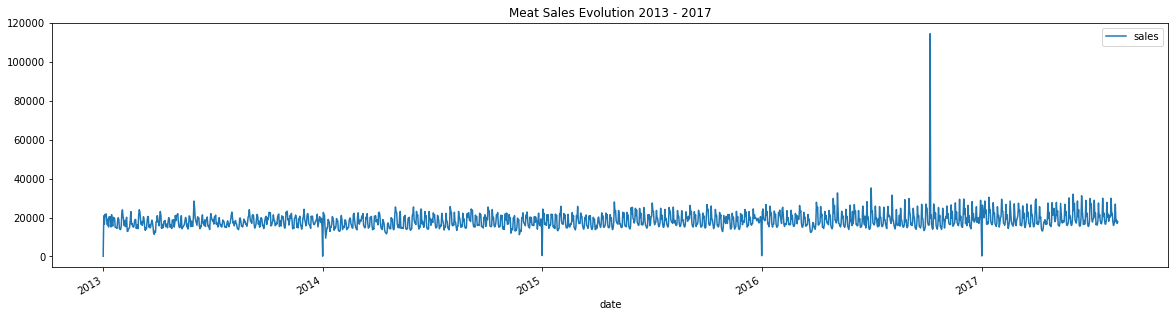

In [3]:
meats.plot(figsize = (20,5) , title = "Meat Sales Evolution 2013 - 2017");

So first of all, I start each of my analysis with some __Exploratory Data Analysis__ . I mainly focus on visuals rather than so much numbers, because I think it´s clearer for the most amount of people. To begin with, we can see that at the beginning of each year sales decline notoriously. Probably because it´s a holiday (the day after new year´s eve). We can also see a tremendous spike of sales during 2016. All these points should be looked at and analyzed as potential __Outliers__ which could affect our model. Other than that, the timeseries seems to be (visually) stationary. 

### __Section 1.1 : Outlier Detection__

C:\Users\marce\anaconda3\envs\dsprophet\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\marce\anaconda3\envs\dsprophet\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


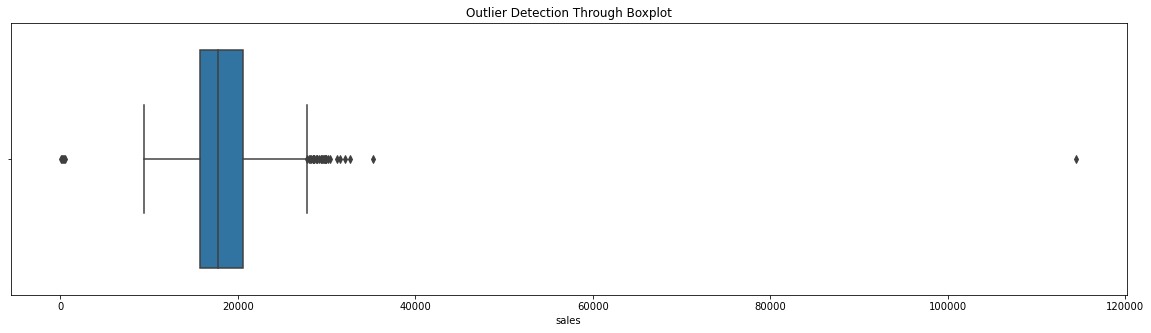

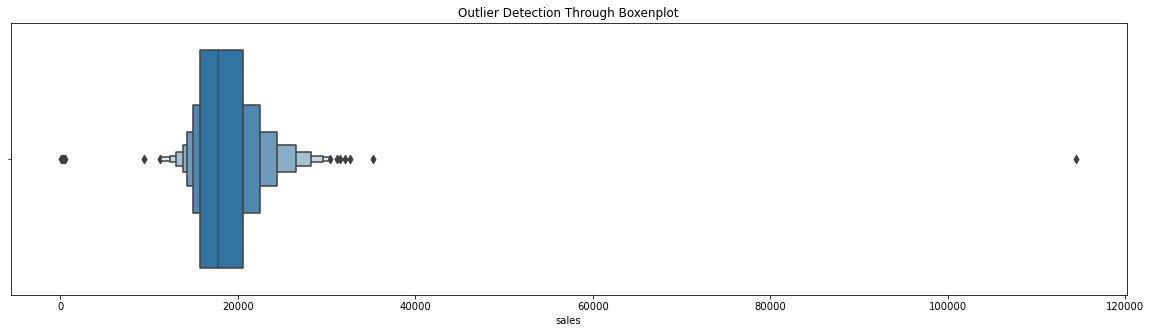

In [4]:
plt.figure(figsize = (20,5))
plt.title("Outlier Detection Through Boxplot")
sns.boxplot(meats['sales'], whis=1.5);
plt.figure(figsize = (20,5))
plt.title("Outlier Detection Through Boxenplot")
sns.boxenplot(meats['sales']);

There are many ways to analyze outliers, both visually and numerically. Visually we can mention the __Box Plot__ and __Boxen Plot or Letter Value Plots__. Both of these box plots show that points falling out of range are potentital outliers. For these dataset, the second plot is more suitable since we have a large dataset and Letter Value Plots adapt in a better way.  

As a matter of fact, we can see that the amount of outliers notoriously decreases when we analyze the second plot. We can see a far right outlier which is the peak in sales noticed before, and we see a group of outliers on the left belonging to the first days of each year. We also see other outliers which we didn´t identify visually.

In [5]:
from pandas.plotting import lag_plot

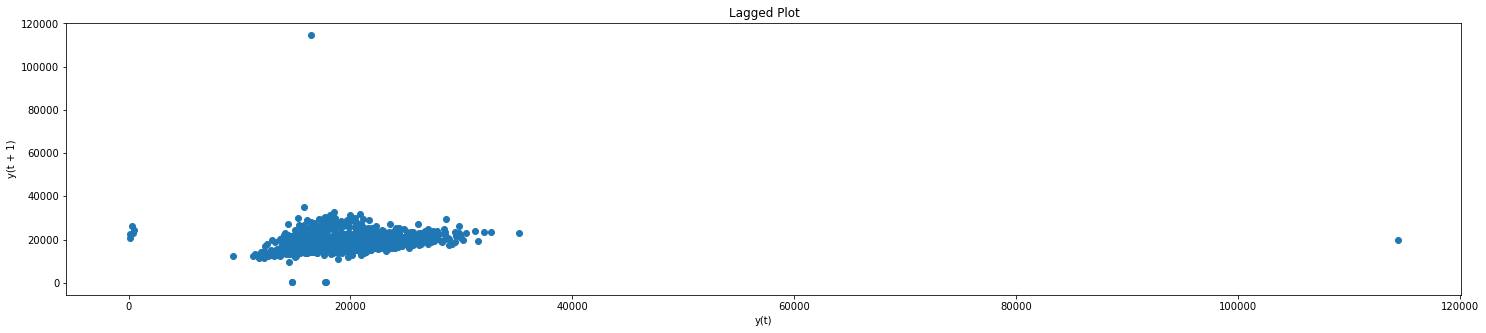

In [6]:
plt.figure(figsize = (25,5))
plt.title("Lagged Plot")
lag_plot(meats, lag=1);

__Z Score Outlier Detection__

In [7]:
data = meats.copy()
data['zscore'] = (data - data.mean())/data.std()
outliers = data[(data['zscore'] <= -3) | (data['zscore'] >= 3)]

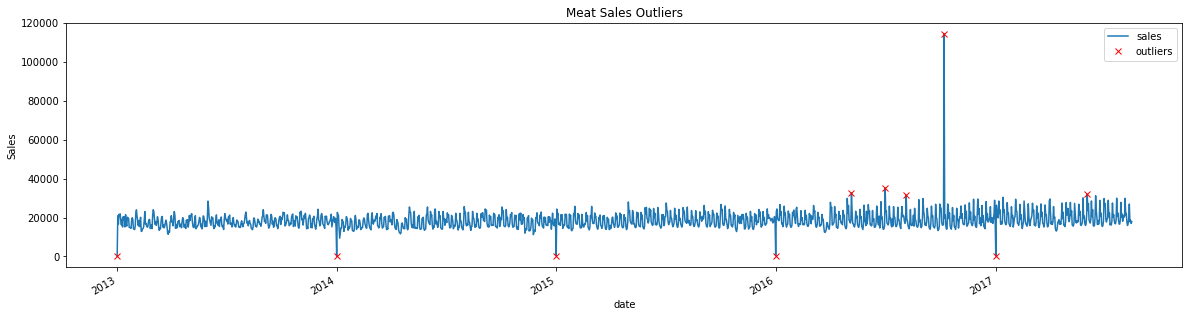

In [8]:
plot_outliers(outliers, meats,"Meat Sales Outliers")

In [9]:
outliers

sales     zscore
date                                
2013-01-01     110.801000  -4.233714
2014-01-01     160.157000  -4.222326
2015-01-01     479.767000  -4.148582
2016-01-01     397.749000  -4.167506
2016-05-06   32640.857018   3.271993
2016-07-01   35206.951950   3.864072
2016-08-05   31499.771101   3.008709
2016-10-07  114430.285038  22.143386
2017-01-01     270.711000  -4.196817
2017-06-02   32031.362095   3.131364

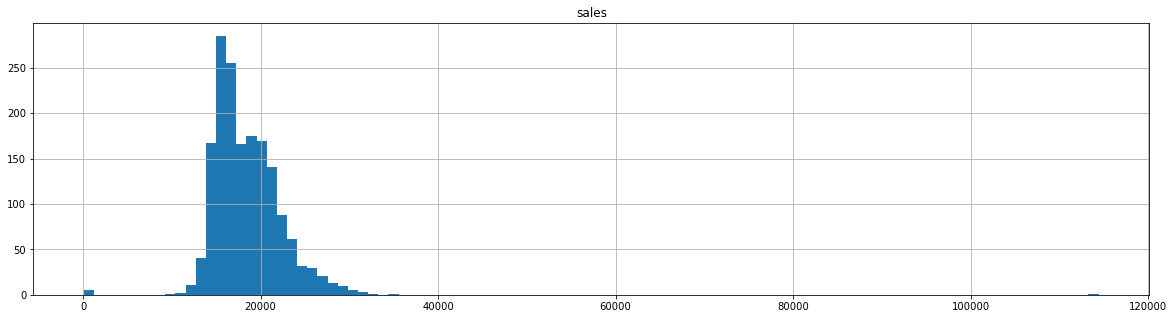

In [10]:
meats.hist(bins = 100 , figsize = (20,5));

In [11]:
from statsmodels.stats.diagnostic import kstest_normal

t_test, p_value = kstest_normal(meats)
if p_value < 0.05:
    print("Reject null hypothesis. Data is not normal")
else:
    print("Fail to reject null hypothesis. Data is normal")

Reject null hypothesis. Data is not normal


### __Modified Z-Score__

In [12]:
import scipy.stats as stats
stats.norm.ppf(0.75)

0.6744897501960817

In [13]:
data = meats.copy()
s = stats.norm.ppf(0.75)
numerator = s*(data - data.median())
MAD = np.abs(data - data.median()).median()
data['m_zscore'] = numerator/MAD
outliers_not_normal = data[(data['m_zscore'] > 4) | (data['m_zscore'] < -4)]
threshold =  5

In [14]:
outliers_not_normal

sales   m_zscore
date                                
2013-01-01     110.801000  -5.058112
2014-01-01     160.157000  -5.043962
2015-01-01     479.767000  -4.952328
2016-01-01     397.749000  -4.975843
2016-05-06   32640.857018   4.268430
2016-07-01   35206.951950   5.004143
2016-10-07  114430.285038  27.717900
2017-01-01     270.711000  -5.012265
2017-06-02   32031.362095   4.093684

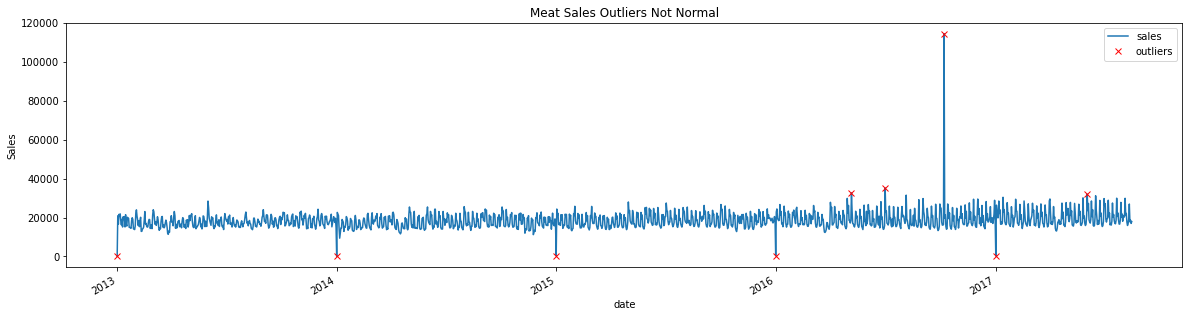

In [15]:
plot_outliers(outliers_not_normal, meats,"Meat Sales Outliers Not Normal")

In [16]:
outliers_not_normal.index

DatetimeIndex(['2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01',
               '2016-05-06', '2016-07-01', '2016-10-07', '2017-01-01',
               '2017-06-02'],
              dtype='datetime64[ns]', name='date', freq=None)

In [17]:
meats_no_outliers = meats.drop(['2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01' , '2016-10-07', '2017-01-01'])

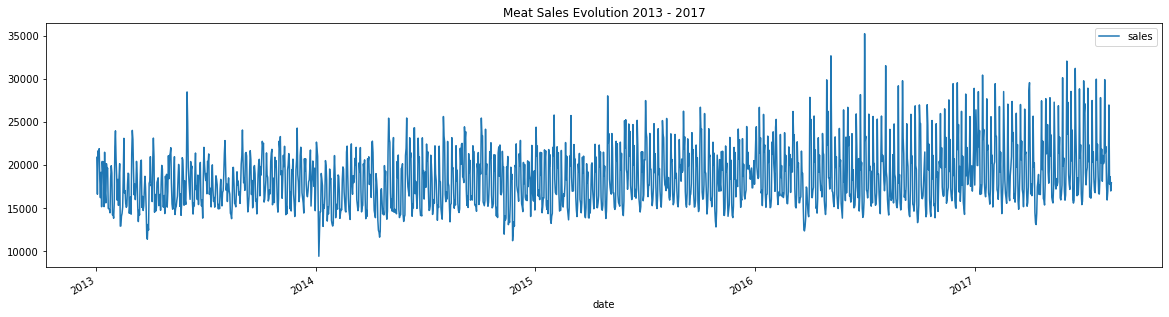

In [18]:
meats_no_outliers.plot(figsize = (20,5) , title = "Meat Sales Evolution 2013 - 2017");

## __Section 2: Data Preparation and Forecasting with Neural Networks__

There are many ways to develop a forecasting model, such as ARIMA, SARIMA, Neural Networks and many more. For these project I will work with two of them: __Neural Networks__ and __Facebook Prophet__. I´m going to use the __one_step_forecast__ function from __Tarek Atwan__ to create the datasets.

### __Section 2.1 : Data Preparation__

In [19]:
dataset = one_step_forecast(meats_no_outliers,7)

In [20]:
meats_no_outliers.head(10)

sales
date                    
2013-01-02  20871.464028
2013-01-03  16597.398113
2013-01-04  21625.963055
2013-01-05  20879.091050
2013-01-06  21880.005115
2013-01-07  18314.175078
2013-01-08  16200.319985
2013-01-09  19139.782952
2013-01-10  15144.950044
2013-01-11  20400.725070

In [21]:
dataset

x_1           x_2           x_3           x_4  \
date                                                                 
2013-01-02  20871.464028  16597.398113  21625.963055  20879.091050   
2013-01-03  16597.398113  21625.963055  20879.091050  21880.005115   
2013-01-04  21625.963055  20879.091050  21880.005115  18314.175078   
2013-01-05  20879.091050  21880.005115  18314.175078  16200.319985   
2013-01-06  21880.005115  18314.175078  16200.319985  19139.782952   
...                  ...           ...           ...           ...   
2017-08-04  29885.105980  21418.266000  22116.619190  17640.570020   
2017-08-05  21418.266000  22116.619190  17640.570020  15925.542060   
2017-08-06  22116.619190  17640.570020  15925.542060  16879.122994   
2017-08-07  17640.570020  15925.542060  16879.122994  19184.939030   
2017-08-08  15925.542060  16879.122994  19184.939030  26944.092010   

                     x_5           x_6           x_7             y  
date                                                                
2013-01-02  21880.005115  18314.175078  16200.319985  19139.782952  
2013-01-03  18314.175078  16200.319985  19139.782952  15144.950044  
2013-01-04  16200.319985  19139.782952  15144.950044  20400.725070  
2013-01-05  19139.782952  15144.950044  20400.725070  19029.047018  
2013-01-06  15144.950044  20400.725070  19029.047018  20346.384960  
...                  ...           ...           ...           ...  
2017-08-04  15925.542060  16879.122994  19184.939030  26944.092010  
2017-08-05  16879.122994  19184.939030  26944.092010  17775.650112  
2017-08-06  19184.939030  26944.092010  17775.650112  18633.015039  
2017-08-07  26944.092010  17775.650112  18633.015039  16975.686040  
2017-08-08  17775.650112  18633.015039  16975.686040  17928.170944  

[1671 rows x 8 columns]

The set is structured in the following way. We are going to use the 7 previous data points to forecast a new data point, that´s why we set the window size to seven. However, this is a custom hyperparameter, you can set whatever window size you want.

Now we need to split the data. When we work with sequencial data, we can´t split it the same way as we do with a classification problem for example. We need to keep the order. 

In [22]:
split_limit = int(len(dataset) * 0.8)
split_limit2 = int((len(dataset) - split_limit) * 0.5)
train = dataset[:split_limit]
val = dataset[split_limit:split_limit + split_limit2]
test = dataset[split_limit + split_limit2:]

Machine Learning and Deep Algorithms usually work better with scaled data, therefore that´s what we are going to do next. It´s important to notice that when we normalize data we have to use the __training mean and training standard deviation__ to normalize __all__ the datasets. If we don´t do that, we would be falling into __Data Leakage__

In [23]:
train_mean = train.mean()
train_sigma = train.std()
train_scaled = (train - train_mean)/train_sigma
val_scaled = (val - train_mean)/train_sigma
test_scaled = (test - train_mean)/train_sigma

We split the __Features__ and __Target__

In [24]:
X_train , y_train = splitter(train_scaled)
X_val , y_val = splitter(val_scaled)
X_test , y_test = splitter(test_scaled)

### __Section 2.2 : Neural Network Model__

In [25]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.layers import BatchNormalization, Dense, GRU, LSTM, Dropout

In [26]:
model = Sequential()
model.add(LSTM(units=40,input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=40,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1))

In [27]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError(),MeanAbsoluteError()])
    
callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
    
history = model.fit(X_train,y_train, shuffle=False, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[callbacks], verbose=1)

Epoch 1/100
42/42 [==============================] - 11s 59ms/step - loss: 0.8757 - root_mean_squared_error: 0.9358 - mean_absolute_error: 0.7768 - val_loss: 1.2243 - val_root_mean_squared_error: 1.1065 - val_mean_absolute_error: 0.9050
Epoch 2/100
42/42 [==============================] - 1s 16ms/step - loss: 0.6937 - root_mean_squared_error: 0.8329 - mean_absolute_error: 0.6622 - val_loss: 0.8879 - val_root_mean_squared_error: 0.9423 - val_mean_absolute_error: 0.7464
Epoch 3/100
42/42 [==============================] - 1s 14ms/step - loss: 0.6677 - root_mean_squared_error: 0.8172 - mean_absolute_error: 0.6332 - val_loss: 0.9803 - val_root_mean_squared_error: 0.9901 - val_mean_absolute_error: 0.7632
Epoch 4/100
42/42 [==============================] - 1s 16ms/step - loss: 0.6292 - root_mean_squared_error: 0.7932 - mean_absolute_error: 0.6165 - val_loss: 0.8827 - val_root_mean_squared_error: 0.9395 - val_mean_absolute_error: 0.7381
Epoch 5/100
42/42 [==============================] - 1s

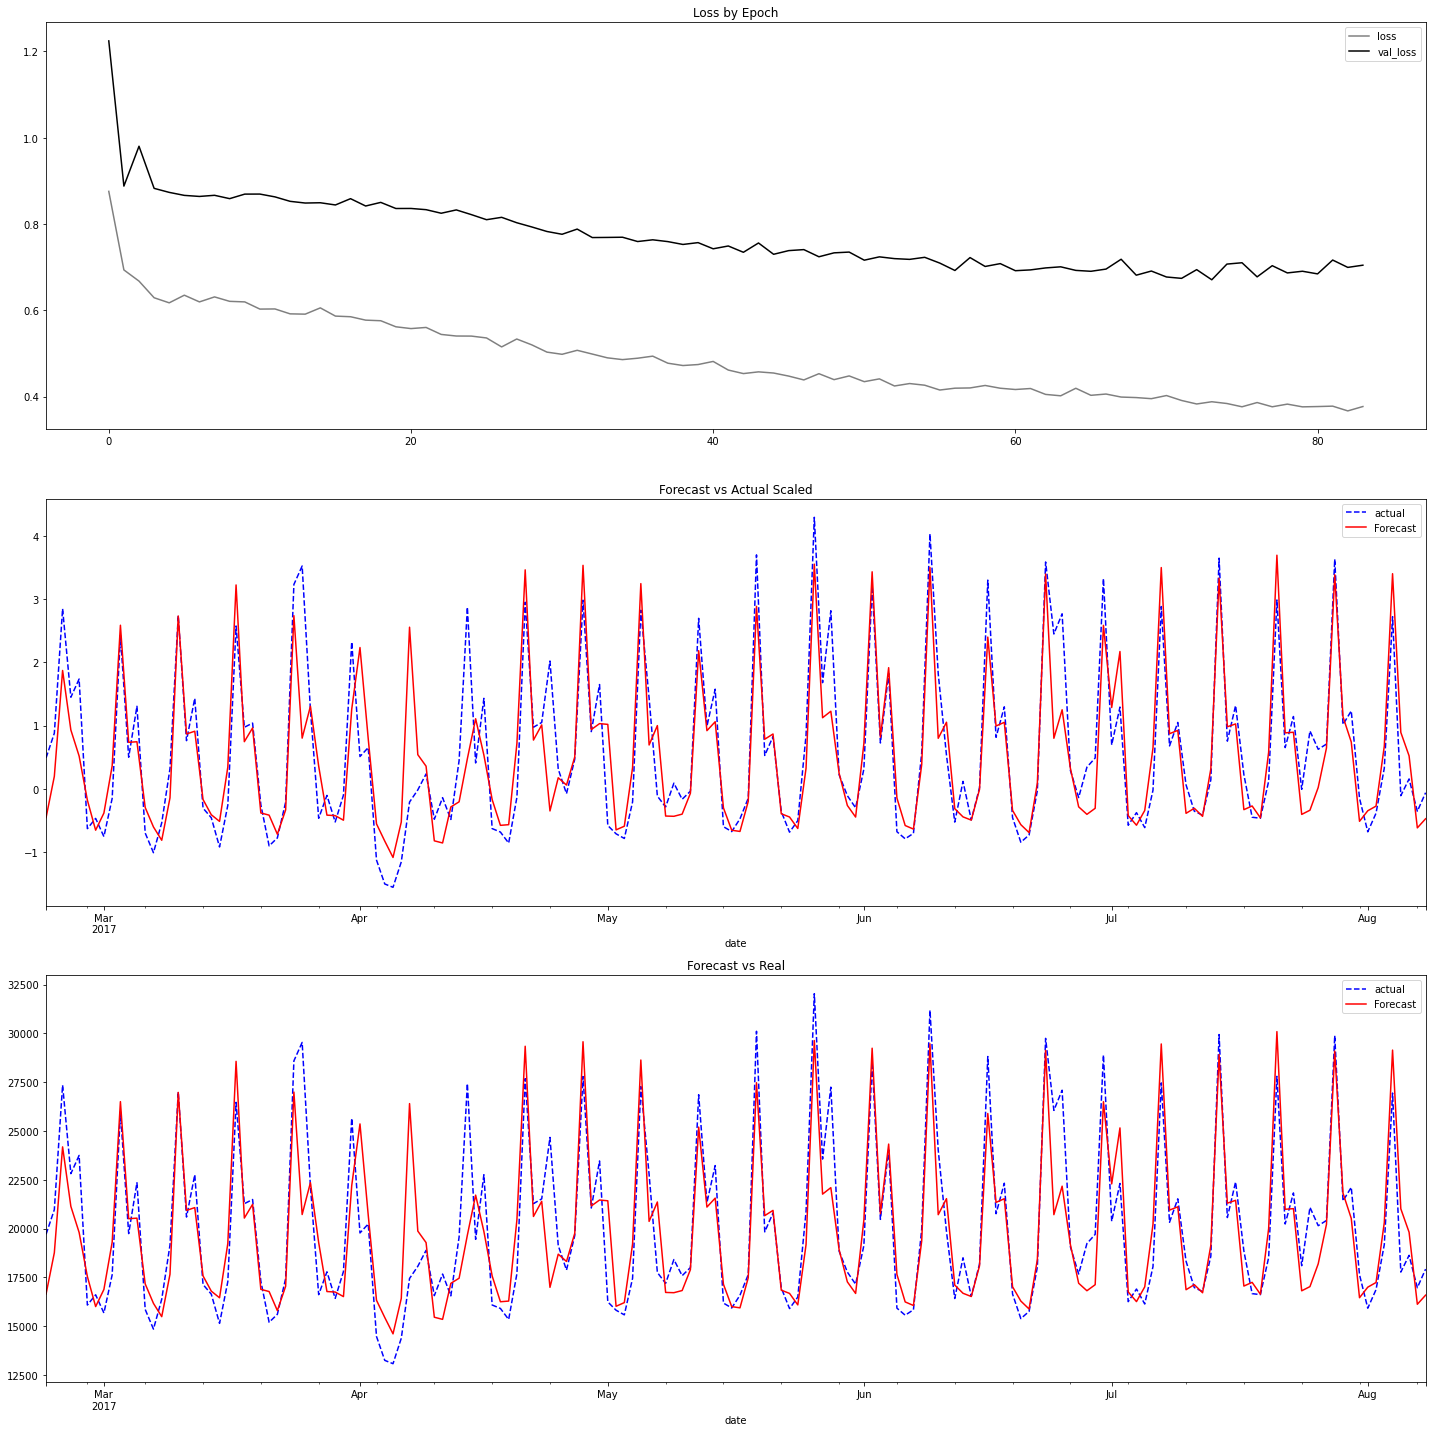

In [28]:
predicted = plot_forecast(model , X_test , y_test ,test_scaled.index , history , train_sigma , train_mean)

### __Section 2.3 : Facebook Prophet__

__Meta__ formerly known as __Facebook__ developed an easy to use algorithm for Time Series Forecasting : __Prophet__. Prophet only requieres a DataFrame with two columns : __ds__ which is the date and __y__ which is the target value.

In [29]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

In [30]:
train_prophet = meats_no_outliers[:1503]
test_prophet = meats_no_outliers[1503:]
train_prophet.reset_index(inplace = True)
test_prophet.reset_index(inplace = True)
train_prophet.columns = ["ds" , "y"]
test_prophet.columns = ["ds" , "y"]

In [31]:
prophet_model = Prophet().fit(train_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
n = len(test_prophet)
future = prophet_model.make_future_dataframe(n, freq='D')

In [33]:
forecast = prophet_model.predict(future)

In [34]:
forecast.head()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2013-01-02  17661.793289  13544.049790  18641.043102  17661.793289   
1 2013-01-03  17661.773245  13986.885565  19476.894116  17661.773245   
2 2013-01-04  17661.753202  20266.763045  25590.453740  17661.753202   
3 2013-01-05  17661.733158  17700.622117  23042.119414  17661.733158   
4 2013-01-06  17661.713115  18080.919256  23177.650615  17661.713115   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  17661.793289    -1551.366594          -1551.366594          -1551.366594   
1  17661.773245     -985.913019           -985.913019           -985.913019   
2  17661.753202     5179.251418           5179.251418           5179.251418   
3  17661.733158     2660.774868           2660.774868           2660.774868   
4  17661.713115     2919.799539           2919.799539           2919.799539   

        weekly  weekly_lower  weekly_upper      yearly  yearly_lower  \
0 -2430.973949  -2430.973949  -2430.973949  879.607356    879.607356   
1 -1831.981264  -1831.981264  -1831.981264  846.068245    846.068245   
2  4371.802994   4371.802994   4371.802994  807.448424    807.448424   
3  1896.404542   1896.404542   1896.404542  764.370326    764.370326   
4  2202.319003   2202.319003   2202.319003  717.480536    717.480536   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0    879.607356                   0.0                         0.0   
1    846.068245                   0.0                         0.0   
2    807.448424                   0.0                         0.0   
3    764.370326                   0.0                         0.0   
4    717.480536                   0.0                         0.0   

   multiplicative_terms_upper          yhat  
0                         0.0  16110.426695  
1                         0.0  16675.860226  
2                         0.0  22841.004619  
3                         0.0  20322.508026  
4                         0.0  20581.512654

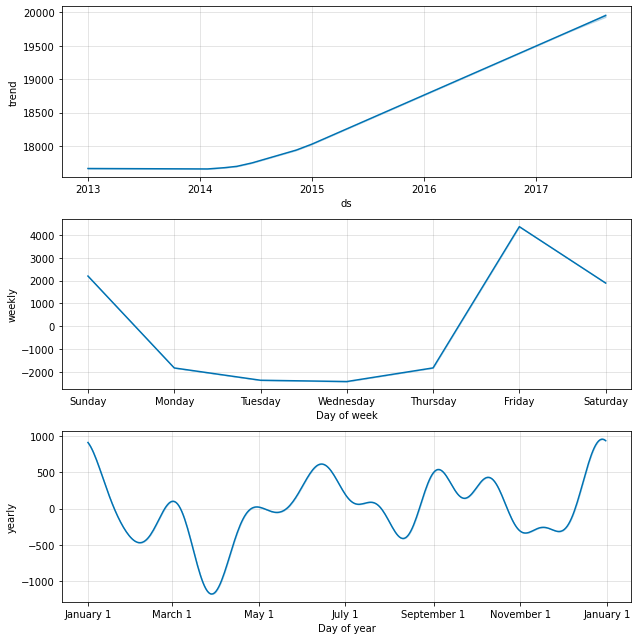

In [35]:
prophet_model.plot_components(forecast); plt.show()

In [36]:
test_forecast = forecast.iloc[len(forecast) - 175 :][['ds' , 'yhat']]

In [37]:
prophet_results = pd.merge(test_forecast , test_prophet)

In [38]:
prophet_results.set_index("ds" , inplace = True)

In [39]:
prophet_results = prophet_results.iloc[7:]

In [40]:
prophet_results.head()

yhat             y
ds                                    
2017-03-01  17284.553766  19711.987960
2017-03-02  17887.547533  20974.111100
2017-03-03  24088.256892  27352.666171
2017-03-04  21602.434390  22816.762910
2017-03-05  21890.428769  23749.936014

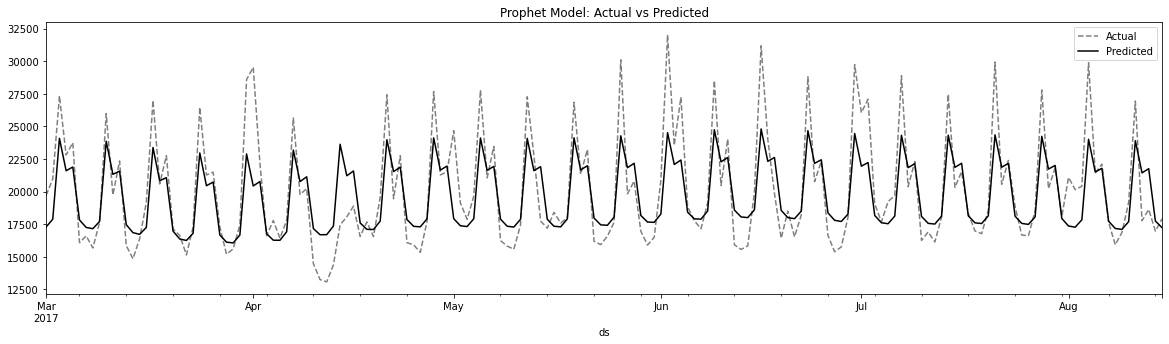

In [41]:
prophet_results["y"].plot(style='k--', alpha=0.5 , figsize = (20,5))
prophet_results["yhat"].plot(style='k')
plt.legend(['Actual', 'Predicted'])
plt.title('Prophet Model: Actual vs Predicted');

In [42]:
total_results = prophet_results

In [43]:
total_results["NeuralNetPrediction"] = predicted.Predicted.values

In [44]:
total_results.columns = ["ProphetPredictions" , "Real" , "NeuralNetPredictions"]

In [45]:
total_results = total_results[["Real" , "NeuralNetPredictions" , "ProphetPredictions"]]

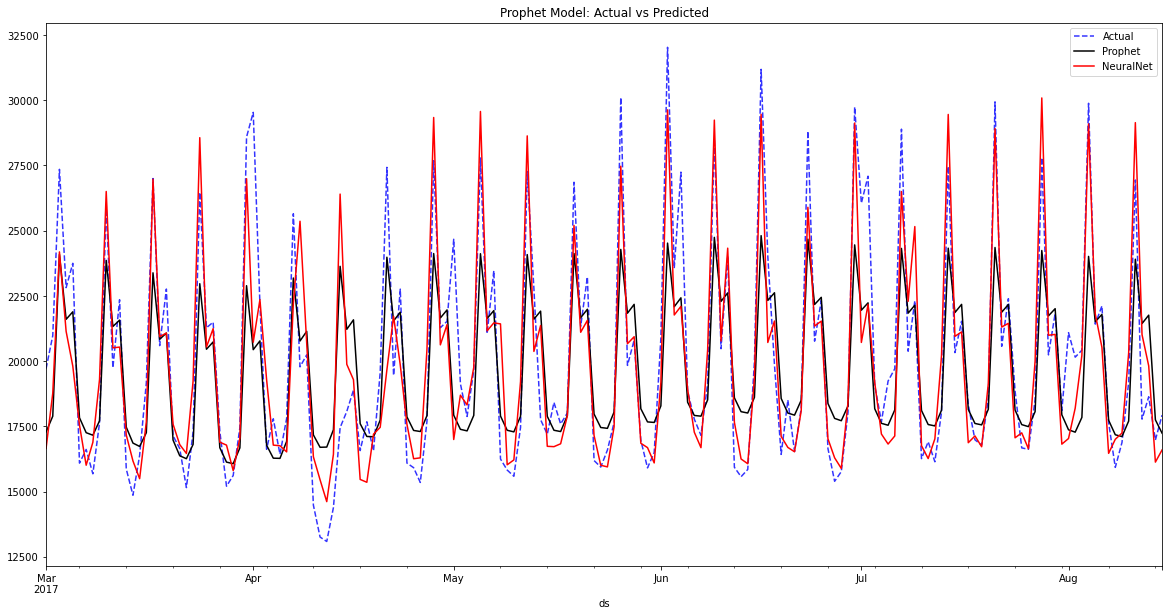

In [46]:
total_results["Real"].plot(style='b--', alpha=0.8 , figsize = (20,10))
total_results["ProphetPredictions"].plot(style='k')
total_results["NeuralNetPredictions"].plot(color = "red")
plt.legend(['Actual', 'Prophet' , "NeuralNet"])
plt.title('Prophet Model: Actual vs Predicted');

In [47]:
total_results

Real  NeuralNetPredictions  ProphetPredictions
ds                                                                
2017-03-01  19711.987960          16654.373047        17284.553766
2017-03-02  20974.111100          18766.000000        17887.547533
2017-03-03  27352.666171          24187.681641        24088.256892
2017-03-04  22816.762910          21140.474609        21602.434390
2017-03-05  23749.936014          19806.166016        21890.428769
...                  ...                   ...                 ...
2017-08-11  26944.092010          29143.199219        23907.254137
2017-08-12  17775.650112          21015.984375        21440.150368
2017-08-13  18633.015039          19817.082031        21761.338279
2017-08-14  16975.686040          16127.580078        17747.744761
2017-08-15  17928.170944          16594.027344        17236.418755

[168 rows x 3 columns]

In [48]:
from sklearn.metrics import mean_absolute_error , mean_squared_error
print(f'MAE for Prophet : {mean_absolute_error(total_results["Real"], total_results["ProphetPredictions"])}')
print(f'MAE for Neural Network : {mean_absolute_error(total_results["Real"], total_results["NeuralNetPredictions"])}')
print(f'MSE for Prophet : {mean_squared_error(total_results["Real"], total_results["ProphetPredictions"])}')
print(f'MSE for Neural Network : {mean_squared_error(total_results["Real"], total_results["NeuralNetPredictions"])}')

MAE for Prophet : 1826.4332368671664
MAE for Neural Network : 1491.2413062447918
MSE for Prophet : 6019396.413816636
MSE for Neural Network : 4642961.62669574
